In [423]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.constants import START, END
from langgraph.graph import StateGraph, MessagesState
from pydantic import BaseModel, Field
from operator import add
from serpapi import GoogleSearch
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.tools import tool
from trustcall import create_extractor
from typing import TypedDict, Literal
from langchain_core.runnables.config import RunnableConfig
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage, ToolMessage
from langgraph.store.base import BaseStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from IPython.display import Markdown, Image, display
from dotenv import dotenv_values
from pypdf import PdfReader
import pandas as pd
import os

from typing_extensions import Optional

In [424]:
env_values = {**dotenv_values(".env.shared"), **dotenv_values(".env.secret")}

os.environ["LANGSMITH_TRACING"] = env_values["LANGSMITH_TRACING"]
os.environ["LANGSMITH_ENDPOINT"] = env_values["LANGSMITH_ENDPOINT"]
os.environ["LANGSMITH_API_KEY"] = env_values["LANGSMITH_API_KEY"]
os.environ["LANGSMITH_PROJECT"] = env_values["LANGSMITH_PROJECT"]
os.environ["OPENAI_API_KEY"] = env_values["OPENAI_API_KEY"]

## Summarization graph

In [425]:
PATH_TO_FILES = "./Data"

In [426]:
def read_csv_xlsx(path: str) -> str:
    if path.endswith(".xlsx"):
        df = pd.read_excel(path)
        return df.to_string(index=False)
    else:
        df = pd.read_csv(path)
        return df.to_string(index=False)

def read_pdf(path: str) -> str:
    with open(path, "rb") as f:
        reader = PdfReader(f)
        text = ""
        for page in reader.pages:
            text += page.extractText()

    return text

def read_docs():
    dirs = os.listdir(PATH_TO_FILES)
    text = ""
    for dir in dirs:
        files = os.listdir(os.path.join(PATH_TO_FILES, dir))
        for file in files:
            if not file.endswith(".pdf"):
                text += read_csv_xlsx(os.path.join(os.path.join(PATH_TO_FILES, dir), file))
            else:
                text += read_pdf(os.path.join(os.path.join(PATH_TO_FILES, dir), file))

    return text

In [427]:
test = read_docs()

In [428]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.4, top_p=0.38)

In [429]:
summarization_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a travel assistant. Help in summarizing the employee profiles, the organizational rules and the travel requirements. Ignore any IDs"),
    ("human", "Summarize this {input}")
])

In [430]:
runnable_summarization = summarization_prompt | llm

In [431]:
output = runnable_summarization.invoke({'input': test}).content

In [432]:
Markdown(output)

**Employee Profiles:**

1. **Alice Doe** - Senior Engineer
   - Travel History: USA, Germany, France (3x)
   - Preferred Airlines: Lufthansa, Delta
   - Preferred Hotels: Marriott, Hilton
   - Meal Preference: Vegetarian
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA

2. **Bob Smith** - Project Manager
   - Travel History: India, UK (2x)
   - Preferred Airlines: British Airways
   - Preferred Hotels: IHG, Hyatt
   - Meal Preference: Vegan
   - Seat Preference: Aisle
   - Visa Requirement: UK, India

3. **Carol Lee** - Data Scientist
   - Travel History: Singapore, Japan (1x)
   - Preferred Airlines: Singapore Airlines
   - Preferred Hotels: Marriott
   - Meal Preference: Non-Veg
   - Seat Preference: Aisle
   - Visa Requirement: Japan, Singapore

4. **David Wong** - Cybersecurity Lead
   - Travel History: Canada, USA, Germany (4x)
   - Preferred Airlines: Air Canada, Delta
   - Preferred Hotels: Hilton
   - Meal Preference: Kosher
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA, Canada

5. **Eva Patel** - Software Engineer
   - Travel History: Remote (0 trips)
   - Preferred Airlines: Emirates
   - Preferred Hotels: Hyatt
   - Meal Preference: Halal
   - Seat Preference: Window
   - Visa Requirement: Schengen

**Organizational Rules:**

1. Max budget per trip per employee is $3,000, region dependent.
2. Business class flights are only for Director level and above.
3. Approval from direct manager is required for travel abroad.
4. Preferred airline partners are Lufthansa, Emirates, and Delta.
5. Hotels must be 4-star or higher for company bookings.
6. Travel insurance is mandatory for international trips.
7. Employees cannot book flights exceeding the budget limit.
8. Visa approval must be completed before flight booking.

**Travel Requirements:**

- **TR001**: Alice Doe to Berlin for a conference from July 15 to July 20, 2025, with a budget of $2,500. Status: Approved.
- **TR002**: Bob Smith to London for a client meeting from August 1 to August 5, 2025, with a budget of $3,000. Status: Pending.
- **TR003**: Carol Lee to Tokyo for research from September 10 to September 20, 2025, with a budget of $4,500. Status: Approved.
- **TR004**: David Wong to Toronto for an internal audit from October 5 to October 15, 2025, with a budget of $3,500. Status: Rejected.
- **TR005**: Eva Patel to Dubai for a business expo from November 1 to November 10, 2025, with a budget of $2,000. Status: Approved.

### Creation of the summary graph

In [433]:
llm = ChatOpenAI(model="gpt-4o", temperature=0, top_p=0.38)

#### States

In [434]:
class SummaryGraphInput(TypedDict):
    summary: str
    text: str

class SummaryGraphOutput(TypedDict):
    summary: str


#### Utils

In [435]:
def read_csv_xlsx(path: str) -> str:
    if path.endswith(".xlsx"):
        df = pd.read_excel(path)
        return df.to_string(index=False)
    else:
        df = pd.read_csv(path)
        return df.to_string(index=False)

def read_pdf(path: str) -> str:
    with open(path, "rb") as f:
        reader = PdfReader(f)
        text = ""
        for page in reader.pages:
            text += page.extractText()

    return text

#### Prompts

In [436]:
summarization_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a travel assistant. Help in summarizing the employee profiles, the organizational rules and the travel requirements. Add the employee IDs also. Ignore any other IDs. Do not provide the output in any font or styles. Provide the summary in a neat structured format."),
    ("human", "Summarize this {input}")
])

#### Nodes

In [437]:
def read_docs(state: SummaryGraphInput):
    PATH_TO_FILES = "./Data"
    dirs = os.listdir(PATH_TO_FILES)
    text = ""
    for dir in dirs:
        files = os.listdir(os.path.join(PATH_TO_FILES, dir))
        for file in files:
            if not file.endswith(".pdf"):
                text += read_csv_xlsx(os.path.join(os.path.join(PATH_TO_FILES, dir), file))
            else:
                text += read_pdf(os.path.join(os.path.join(PATH_TO_FILES, dir), file))

    return {'text': text}

In [438]:
def summarize(state: SummaryGraphInput):
    text = state['text']
    runnable_summarization = summarization_prompt | llm
    output = runnable_summarization.invoke({'input': text}).content
    with open("./summary/summary.txt", "w") as f:
        f.write(output)
    return {'summary': output}

In [439]:
graph_summarizer_builder = StateGraph(SummaryGraphInput, output=SummaryGraphOutput)

graph_summarizer_builder.add_node("read documents", read_docs)
graph_summarizer_builder.add_node("summarize documents", summarize)

graph_summarizer_builder.add_edge(START, "read documents")
graph_summarizer_builder.add_edge("read documents", "summarize documents")
graph_summarizer_builder.add_edge("summarize documents", END)

memory = MemorySaver()
graph_summarizer = graph_summarizer_builder.compile()

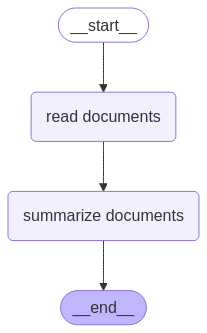

In [440]:
display(Image(graph_summarizer.get_graph().draw_mermaid_png()))

In [441]:
Markdown(graph_summarizer.invoke({}, config={'configurable': {'thread_id': "summarizer_4"}})['summary'])

Employee Profiles:
1. Employee ID: 1001
   - Name: Alice Doe
   - Role: Senior Engineer
   - Travel History: USA, Germany, France (3x)
   - Preferred Airlines: Lufthansa, Delta
   - Preferred Hotels: Marriott, Hilton
   - Meal Preference: Vegetarian
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA

2. Employee ID: 1002
   - Name: Bob Smith
   - Role: Project Manager
   - Travel History: India, UK (2x)
   - Preferred Airlines: British Airways
   - Preferred Hotels: IHG, Hyatt
   - Meal Preference: Vegan
   - Seat Preference: Aisle
   - Visa Requirement: UK, India

3. Employee ID: 1003
   - Name: Carol Lee
   - Role: Data Scientist
   - Travel History: Singapore, Japan (1x)
   - Preferred Airlines: Singapore Airlines
   - Preferred Hotels: Marriott
   - Meal Preference: Non-Veg
   - Seat Preference: Aisle
   - Visa Requirement: Japan, Singapore

4. Employee ID: 1004
   - Name: David Wong
   - Role: Cybersecurity Lead
   - Travel History: Canada, USA, Germany (4x)
   - Preferred Airlines: Air Canada, Delta
   - Preferred Hotels: Hilton
   - Meal Preference: Kosher
   - Seat Preference: Window
   - Visa Requirement: Schengen, USA, Canada

5. Employee ID: 1005
   - Name: Eva Patel
   - Role: Software Engineer
   - Travel History: Remote (0 trips)
   - Preferred Airlines: Emirates
   - Preferred Hotels: Hyatt
   - Meal Preference: Halal
   - Seat Preference: Window
   - Visa Requirement: Schengen

Organizational Rules:
1. Max budget per trip per employee: $3,000 (Region dependent)
2. Business class flights only for Director level & above
3. Approval from direct manager required for travel abroad
4. Preferred airline partners: Lufthansa, Emirates, Delta
5. Hotels must be 4-star or higher for company bookings
6. Travel insurance mandatory for international trips
7. Employees cannot book flights exceeding the budget limit
8. Visa approval must be completed before flight booking

Travel Requirements:
1. Employee ID: 1001
   - Destination: Berlin
   - Purpose: Conference
   - Start Date: 2025-07-15
   - End Date: 2025-07-20
   - Budget Limit: $2500
   - Approval Status: Approved

2. Employee ID: 1002
   - Destination: London
   - Purpose: Client Meeting
   - Start Date: 2025-08-01
   - End Date: 2025-08-05
   - Budget Limit: $3000
   - Approval Status: Pending

3. Employee ID: 1003
   - Destination: Tokyo
   - Purpose: Research
   - Start Date: 2025-09-10
   - End Date: 2025-09-20
   - Budget Limit: $4500
   - Approval Status: Approved

4. Employee ID: 1004
   - Destination: Toronto
   - Purpose: Internal Audit
   - Start Date: 2025-10-05
   - End Date: 2025-10-15
   - Budget Limit: $3500
   - Approval Status: Rejected

5. Employee ID: 1005
   - Destination: Dubai
   - Purpose: Business Expo
   - Start Date: 2025-11-01
   - End Date: 2025-11-10
   - Budget Limit: $2000
   - Approval Status: Approved

## Travel Agent AI

### Creation of the graph

#### Output Formats

In [442]:
class Profile(BaseModel):
    travel_history: str = Field(description="The travel history of the employee.")
    preferences: str = Field(description="The preferences s (airlines, hotels, window/aisle, meal choice, etc.) of the employee.")
    role_specific_permissions: str = Field(description="The roles specific to this employee.")
    likes: str | None = Field(description="The likes of the employee.")
    dislikes: str | None = Field(description="The dislikes of the employee.")
    place_of_stay: str | None = Field(description="The place of stay of the employee, during the travel")

class TravelRequirements(BaseModel):
    destination: str = Field(description="The destination of travel the employee.")
    source: str | None = Field(description="The place from which the employee will start travelling")
    purpose: Literal['leisure', 'business'] = Field(description="The purpose of travel the employee.")
    date_of_departure: str = Field(description="The date of departure of the employee.")
    date_of_arrival: str = Field(description="The date of arrival of the employee.")
    duration: str = Field(description="The duration of travel the employee.")

class OrganizationalRules(BaseModel):
    travel_budgets: str = Field(description="The travel budgets of the organization for each cadre of employee")
    approval_hierarchies: str= Field(description="The approval hierarchies for each employee.")
    preferred_vendors: str = Field(description="The preferred vendors for the organization.")
    visa_requirements: str = Field(description="The type of visa requirements for the travel.")

class Traveller(BaseModel):
    name: str = Field(description="The name of the employee.")
    employee_id: str = Field(description="The ID of the employee.")
    profile: Profile = Field(description="The profile of the employee.")
    travel_requirements: TravelRequirements = Field(description="The travel requirements for the employee.")
    organizational_rules: OrganizationalRules = Field(description="The organizational rules for the employee.")

class Travellers(BaseModel):
    travellers: list[Traveller] = Field(description="The list of travellers.")


In [443]:
from pprint import pprint

In [444]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

trustcall_extractor = create_extractor(
    llm,
    tools=[Travellers],
    tool_choice="Travellers"
)

In [445]:
with open("./summary/summary.txt", "r") as f:
    data = f.read()

In [446]:
system_msg = "Extract the profiles of all employees from the given data. {data}"
trustcaller_system_message = SystemMessage(content=system_msg.format(data=data))

In [447]:
result = trustcall_extractor.invoke({"messages": [trustcaller_system_message]})

In [448]:
schema = result['responses']

In [449]:
schema[0].model_dump()

{'travellers': [{'name': 'Alice Doe',
   'employee_id': '1001',
   'profile': {'travel_history': 'USA, Germany, France (3x)',
    'preferences': 'Preferred Airlines: Lufthansa, Delta; Preferred Hotels: Marriott, Hilton; Meal Preference: Vegetarian; Seat Preference: Window',
    'role_specific_permissions': 'Senior Engineer',
    'likes': None,
    'dislikes': None,
    'place_of_stay': None},
   'travel_requirements': {'destination': 'Berlin',
    'source': None,
    'purpose': 'business',
    'date_of_departure': '2025-07-15',
    'date_of_arrival': '2025-07-20',
    'duration': '5 days'},
   'organizational_rules': {'travel_budgets': 'Max budget per trip per employee: $3,000 (Region dependent)',
    'approval_hierarchies': 'Approval from direct manager required for travel abroad',
    'preferred_vendors': 'Preferred airline partners: Lufthansa, Emirates, Delta; Hotels must be 4-star or higher for company bookings',
    'visa_requirements': 'Visa approval must be completed before flig

In [450]:
travellers =  result["messages"][0].tool_calls[0]['args']['travellers']

In [451]:
in_mem_store = InMemoryStore()


for traveller in travellers:
    key = traveller.get("employee_id", None)
    if key is not None:
        namespace = ("memory", key.lower())
        in_mem_store.put(namespace, "traveler", traveller)


In [452]:
for m in in_mem_store.search(("memory", "1001")):
    pprint(m)

Item(namespace=['memory', '1001'], key='traveler', value={'name': 'Alice Doe', 'employee_id': '1001', 'profile': {'travel_history': 'USA, Germany, France (3x)', 'preferences': 'Preferred Airlines: Lufthansa, Delta; Preferred Hotels: Marriott, Hilton; Meal Preference: Vegetarian; Seat Preference: Window', 'role_specific_permissions': 'Senior Engineer', 'likes': None, 'dislikes': None, 'place_of_stay': None}, 'travel_requirements': {'destination': 'Berlin', 'source': None, 'purpose': 'business', 'date_of_departure': '2025-07-15', 'date_of_arrival': '2025-07-20', 'duration': '5 days'}, 'organizational_rules': {'travel_budgets': 'Max budget per trip per employee: $3,000 (Region dependent)', 'approval_hierarchies': 'Approval from direct manager required for travel abroad', 'preferred_vendors': 'Preferred airline partners: Lufthansa, Emirates, Delta; Hotels must be 4-star or higher for company bookings', 'visa_requirements': 'Visa approval must be completed before flight booking'}}, created_

#### States

In [453]:
class TravelAgent(MessagesState):
    profile: Traveller
    output: str
    prompt: str
    summary: str

In [454]:
class ToolCalls(TypedDict):
    tools: Literal['flight', 'traffic', 'weather', 'hotel']

#### Prompts

In [455]:
travel_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a travel assistant. Understand the summary {summary} and help provide responses.
    Help provide the itenary, suggest good hotels, the type of transport, the weather, the flight details, and help mark the calender also. You are essentially a travel concierge. Only respond to travel related questions.
    """),
    ("placeholder", "{history}"),
    ("human", "{prompt}")
])

#### Create Nodes

In [456]:
def read_profile(state: TravelAgent, config: RunnableConfig, store: BaseStore):
    id = config['configurable']['user_id']
    namespace = ("memory", id)
    profile = store.get(namespace, "traveler")
    state['profile'] = profile.value
    return state

In [457]:
def check_profiles(state: TravelAgent):
    profile = state['profile']
    if profile is None:
        return END
    else:
        return "chatbot"


In [458]:
summarization_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant, who helps in summarizing the conversation.
    Conversation: {messages}"""),
    ("human", "Summarize the conversation")
])

In [459]:
def route_ai(state: TravelAgent):
    messages = state['messages']
    count = 0
    for message in messages:
        if isinstance(message, AIMessage) and count < 5:
            if message.content:
                count += 1
    print(count)
    if count >= 5:
        return "summarizer and updater"
    else:
        return END

In [460]:
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation only if necessary. Do not change the organization rules. If no changes are necessary then return None"""

In [461]:
def summarizer_and_updater(state: TravelAgent, config: RunnableConfig, store: BaseStore):
    messages = state['messages']
    runnable_summarizer = summarization_prompt | llm
    extractor = create_extractor(
        llm,
        tools=[Traveller],
        tool_choice="Traveller"
    )
    summary = state.get('summary', "")
    output = runnable_summarizer.invoke({'messages': messages}).content
    summary += output
    deleted_messages = [RemoveMessage(id=message.id) for message in messages[:-4]]
    profile = state['profile']
    json_profile = {"Traveller": profile}

    result = extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)] + messages, 'existing': json_profile})
    updated_profile = result['responses'][0].model_dump()
    store.put(("memory", config['configurable']['user_id']), 'traveler', updated_profile)
    state['summary'] = summary
    state['messages'] = deleted_messages
    return state

In [540]:
chatbot_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a travel assistant. Help answer questions based on the profile. Analyze the profile and give relevant suggestions according to the profile.
    The order of precedence for suggestions is likes, dislikes and then preferences. Adhere to the organizational rules for budget and other corporate matters.
    The itinerary must be in a well structured format with the most likely to visit places first. Do not provide more than 5 suggestions. Take into account if there is any meetings when providing the time for leisure activities. You are essentially a travel concierge.
    If there is some ambiguity in the question posed by the user, analyze the history to make some inferences, if that also does not work then ask a follow up question to rectify the ambiguity.
    Retrieve all the  details regarding flight booking and hotel booking,from the profile, including the dates of travel and dates of stay. If the details are not present, then ask the user to clarify the details.
    If there is any error in fetching the data, ask the user to change the details.
    For the flight details and booking, use the get_flight_data tool. Make sure to provide the IATA code when using this tool.
    Answer questions only related to travelling.
    Summary of the conversation (can be empty also): {summary}
    Reply from the tools (can be empty also): {reply}
    If there is a reply from the tool calls, then provide the output based on the reply from the tool.
    Profile: {profile}"""),
    ("placeholder", "{messages}"),
    ("human", "{input}")

])

In [541]:
def chatbot(state: TravelAgent):
    prompt = state['prompt']
    summary = state.get('summary', None)
    profile = state['profile']
    messages = state['messages']
    reply = ""
    if summary is None:
        # print("Inside")
        summary = ""
        last_instance = messages[-1]
        if isinstance(last_instance, ToolMessage):
            reply = last_instance.content
            if isinstance(summary, list):
                messages.pop()
                messages.pop()
    # print(summary)
    runnable_chatbot = chatbot_prompt | llm.bind_tools(tools, parallel_tool_calls=False)
    output = runnable_chatbot.invoke({'input': prompt, 'summary': summary, "profile": profile, "reply": reply, 'messages': messages})
    state['output'] = output.content
    state['messages'] = [output]
    return state

In [542]:
import json

In [567]:
@tool
def get_flight_data(departure_city:str, arrival_city:str, arrival_date:str | None, outbound_date:str, currency:str="USD", type:str="1", travel_class:str="1", multi_city_json:str=None, adults:str="1", children:str="0", sort_by:str="1", stops:str="0", return_times:str=None, layover_duration:str=None, max_price:str=None) -> dict:
    """
    Fetch flight details using SerpAPI.

    Parameters:
    departure_id (str): Name of the departure city in IATA code (e.g., 'New York').
    arrival_id (str): Name of the arrival city in IATA code (e.g., 'London').
    arrival_date (str | None): Return date in YYYY-MM-DD format.
    outbound_date (str): Departure date in YYYY-MM-DD format.
    currency (str): Parameter defines the currency of the returned prices.
    type (str): Parameter defines the type of the flights. Available options:

        1 - Round trip (default)
        2 - One way
        3 - Multi-city


    travel_class (str): Parameter defines the travel class.
            Available options:
            1 - Economy (default)
            2 - Premium economy
            3 - Business
            4 - First

    multi_city_json (dict): Parameter defines the flight information for multi-city flights. It's a JSON string containing multiple flight information objects. Each object should contain the following fields:

departure_id - The departure airport code or location kgmid. The format is the same as the main departure_id parameter.
arrival_id - The arrival airport code or location kgmid. The format is the same as the main arrival_id parameter.
date - Flight date. The format is the same as the outbound_date parameter.
times - Time range for the flight. The format is the same as the outbound_times parameter. This parameter is optional.

Example:
[{"departure_id":"CDG","arrival_id":"NRT","date":"2025-04-01"},{"departure_id":"NRT","arrival_id":"LAX,SEA","date":"2025-04-08"},{"departure_id":"LAX,SEA","arrival_id":"AUS","date":"2025-04-15","times":"8,18,9,23"}]

    adults (str): Number of adults
    children (str): Number of children
    sort_by (str): Parameter defines the sorting order of the results.
            Available options:

            1 - Top flights (default)
            2 - Price
            3 - Departure time
            4 - Arrival time
            5 - Duration
            6 - Emissions
    stops (str): Parameter defines the number of stops during the flight.
                Available options:

                0 - Any number of stops (default)
                1 - Nonstop only
                2 - 1 stop or fewer
                3 - 2 stops or fewer
    max_price (str): Maximum price of the ticket.
    return_times (str): Parameter defines the return times range. It's a string containing two (for departure only) or four (for departure and arrival) comma-separated numbers. Each number represents the beginning of an hour. For example:

        4,18: 4:00 AM - 7:00 PM departure
        0,18: 12:00 AM - 7:00 PM departure
        19,23: 7:00 PM - 12:00 AM departure
        4,18,3,19: 4:00 AM - 7:00 PM departure, 3:00 AM - 8:00 PM arrival
        0,23,3,19: unrestricted departure, 3:00 AM - 8:00 PM arrival

    layover_duration (str): Parameter defines the layover duration, in minutes. It's a string containing two comma-separated numbers. For example, specify 90,330 for 1 hr 30 min - 5 hr 30 min.

    Returns:
    dict: Flight details if available, else an error message.
    """
    params = {
        "engine": "google_flights",
        "departure_id": departure_city,
        "arrival_id": arrival_city,
        "return_date": arrival_date,
        "outbound_date": outbound_date,
        "api_key": env_values["SERP_API_KEY"],
        "currency": currency,
        "type": type,
        "travel_class": travel_class,
        "multi_city_json": multi_city_json,
        "adults": adults,
        "children": children,
        "sort_by": sort_by,
        "max_price": max_price,
        "return_times": return_times,
        "layover_duration": layover_duration,
        "stops": stops,
    }

    try:
        search = GoogleSearch(params)
        results = search.get_dict()
        results = results['best_flights'][:10]
        # print(results)
        cleaned_flights = [clean_flight_data(flight) for flight in results]
        tidy_json = json.dumps(cleaned_flights, indent=4)
        # print(tidy_json)
        return tidy_json
    except:
        return "There are no such flights for the given criteria."
    # if results:
    #     return results["flights_results"][:10]  # Return top 10 results
    # else:
    #     return {"error": "Failed to fetch data or no flights found"}


# Example usage
# api_key = "your_serpapi_key"
# flights = get_flight_data(api_key, "New York", "London", "2025-04-01")
# print(flights)


In [568]:
def clean_flight_data(flight_data):
    # Remove airline_logo and departure_token from the top-level dictionary
    flight_data.pop('departure_token', None)
    flight_data.pop('airline_logo', None)

    # Iterate through flights and remove airline_logo from each flight
    for flight in flight_data.get('flights', []):
        flight.pop('airline_logo', None)

    return flight_data

In [569]:
# get_flight_data("BLR", "BER", "2025-07-20", "2025-07-15")

In [570]:
tools = [get_flight_data]

In [571]:
tools_node = ToolNode(tools)

In [572]:
graph_chatbot_builder = StateGraph(TravelAgent)

graph_chatbot_builder.add_node("read profile", read_profile)
graph_chatbot_builder.add_node("chatbot", chatbot)
graph_chatbot_builder.add_node("summarizer and updater", summarizer_and_updater)
graph_chatbot_builder.add_node("tools", tools_node)

graph_chatbot_builder.add_edge(START, "read profile")
graph_chatbot_builder.add_conditional_edges("read profile", check_profiles, ["chatbot", END])
graph_chatbot_builder.add_conditional_edges("chatbot", route_ai, ["summarizer and updater", END])
graph_chatbot_builder.add_conditional_edges("chatbot", tools_condition)
graph_chatbot_builder.add_edge("tools", "chatbot")
graph_chatbot_builder.add_edge("summarizer and updater", END)

memory = MemorySaver()
store = InMemoryStore()
graph_chatbot = graph_chatbot_builder.compile(checkpointer=memory, store=in_mem_store, debug=False)

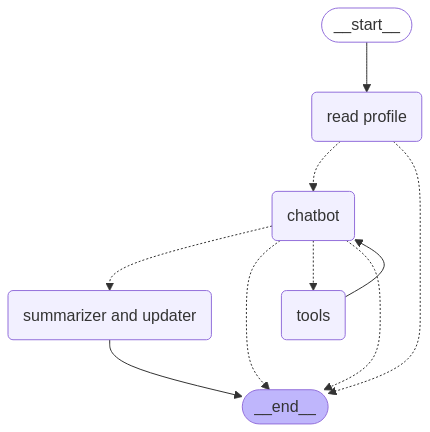

In [224]:
display(Image(graph_chatbot.get_graph().draw_mermaid_png()))

In [549]:
config = {'configurable': {'thread_id': "chatbot-new-47", "user_id": "1001"}}

In [562]:
# for _ in range(3):
user_input = input()
test = graph_chatbot.invoke({"prompt": user_input, "messages": [("human", user_input)]}, config=config)
    # print(test['output'])

3
3
3
3
3
3
3
3
3
3
3
3


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [561]:
print(test['output'])

It seems there was an error in fetching the flight data. Could you please specify the exact city in California you would like to fly to, such as Los Angeles (LAX) or San Francisco (SFO)? This will help me provide the most accurate flight details for you.
